In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def plot_errors(plotcols, test_data, train_data):
    test_diff = test_data['outofsample_error']
    train_diff = train_data['insample_error']
    
    test_data['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
    test_data['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
    test_plot = test_data[plotcols].copy().drop_duplicates()
    
    train_data['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
    train_data['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
    train_plot = train_data[plotcols].copy().drop_duplicates()
    
    trainx = pd.date_range(start=min(train_data.index),end=max(train_data.index),periods=train_plot.shape[0])
    testx = pd.date_range(start=min(test_data.index),end=max(test_data.index),periods=test_plot.shape[0])
    
    fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
    for i,col in enumerate(plotcols):
        axs[i].plot(trainx,train_plot[col],color='green',label='in-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    for i,col in enumerate(plotcols):
        axs[i].plot(testx,test_plot[col],color='purple',label='out-of-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    plt.show()

def retrain(train_data,test_data,retraining_frequency):
    retraining_i = np.arange(retraining_frequency,len(test_dates),retraining_frequency)
    retraining_dates = test_dates[retraining_i].reset_index(drop=True)
    print(f"retraining dates:\n{retraining_dates}")
    for i,date in enumerate(retraining_dates):
        if i<len(retraining_dates)-1:
            print()
            print(date.strftime('%c'))
            new_train = pd.concat([train_data,test_data[test_data.index<=date]],ignore_index=False).copy().dropna(how='any',axis=1).reset_index(drop=False)
            new_test = test_data[(test_data.index>date)&(test_data.index<=retraining_dates[i+1])].reset_index(drop=False)
            arrs = trainer.get_train_test_arrays(new_train, new_test)
            train_X = arrs['train_X']
            train_y = arrs['train_y']
            test_X = arrs['test_X']
            test_y = arrs['test_y']
            preprocessor = trainer.preprocess()
            retrained_model = trainer.run_dnn(preprocessor,train_X,train_y)
            train_test = trainer.test_prediction_accuracy(new_train,new_test,retrained_model)
            new_test_data = train_test['test_data'].set_index('calculation_date')
            new_train_data = train_test['train_data'].set_index('calculation_date')
            print()
            plot_errors(plotcols,new_test_data,new_train_data)
    return retrained_model

# loading model

In [3]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = [f for f in os.listdir(models_dir) if f.find('.')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_11_01 180435470848 short-term cboe asians
1     2024_11_01 195924619203 live cboe barriers
2     2024_11_01 204910611379 bloomberg barriers
3     2024_11_01 205356527985 bloomberg asians
4     2024_11_02 113141414136 cboe asians
5     2024_11_02 113706914873 cboe barriers
6     2024_11_03 145046372112 cboe asians


# loading data

0     2024_11_03 145046372112 cboe asians test_data.csv
1     2024_11_03 145046372112 cboe asians train_data.csv
2     2024_11_03 145046372112 cboe asians.pkl

spot price 
0       4962.00
1       4963.00
2       4963.25
3       4963.50
4       4963.75
         ...   
1565    5864.25
1566    5864.50
1567    5865.00
1568    5865.50
1569    5866.50
Name: spot_price, Length: 1570, dtype: float64

strike price 
0       2481.0
1       2482.0
2       2483.0
3       2490.0
4       2493.0
         ...  
3767    8795.0
3768    8796.0
3769    8797.0
3770    8798.0
3771    8799.0
Name: strike_price, Length: 3772, dtype: float64

days to maturity 
0     7
1    28
2    84
Name: days_to_maturity, dtype: int64

risk free rate 
0    0.04
Name: risk_free_rate, dtype: float64

dividend rate 
0    0.0
Name: dividend_rate, dtype: float64

kappa 
0         0.000824
1         0.001284
2         0.002276
3         0.003055
4         0.003069
           ...    
2238    168.279772
2239    172.133058
2240    198

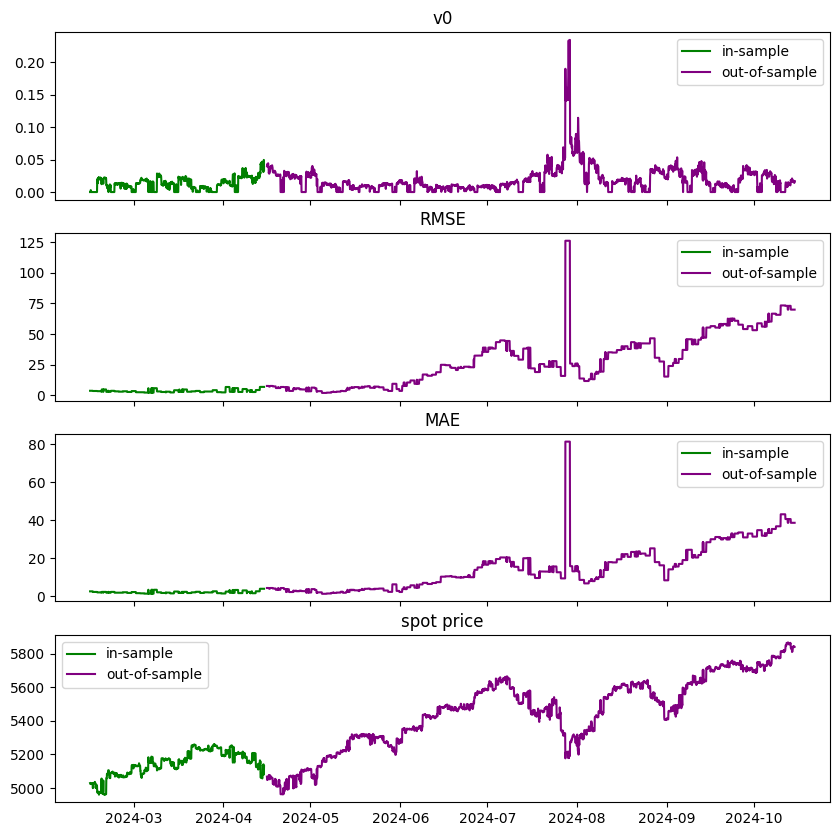

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,...,eta,v0,date,asian,observed_price,outofsample_target,outofsample_prediction,outofsample_error,RMSE,MAE
calculation_date,,,,,,,,,,,,,,,,,,,,,
2024-04-16,5068.00,6335.0,84,1.0,84,0,geometric,call,0.04,0.0,...,3.530188,0.039785,2024-04-17,0.024924,0.048747,0.048747,0.139395,0.090648,7.629078,4.368485
2024-04-16,5048.25,7572.0,28,4.0,7,0,arithmetic,put,0.04,0.0,...,2.281503,0.043115,2024-04-17,2506.542127,2506.577727,2506.577727,2506.292786,-0.284941,7.629078,4.368485
2024-04-16,5048.25,2524.0,28,1.0,28,0,geometric,call,0.04,0.0,...,2.281503,0.043115,2024-04-17,2523.082748,2523.140834,2523.140834,2521.936701,-1.204133,7.629078,4.368485
2024-04-16,5048.25,2524.0,28,1.0,28,0,arithmetic,call,0.04,0.0,...,2.281503,0.043115,2024-04-17,2524.376024,2524.402021,2524.402021,2523.222775,-1.179245,7.629078,4.368485
2024-04-16,5048.25,3786.0,28,1.0,28,0,geometric,call,0.04,0.0,...,2.281503,0.043115,2024-04-17,1264.962461,1264.967275,1264.967275,1265.960116,0.992841,7.629078,4.368485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-15,5840.25,5840.0,7,1.0,7,0,geometric,call,0.04,0.0,...,2.056881,0.017049,2024-10-16,26.885088,26.858376,26.858376,0.568698,-26.289678,69.973905,38.705412
2024-10-15,5840.25,5840.0,7,1.0,7,0,geometric,put,0.04,0.0,...,2.056881,0.017049,2024-10-16,24.047529,24.041505,24.041505,4.942896,-19.098609,69.973905,38.705412
2024-10-15,5840.25,5840.0,7,1.0,7,0,arithmetic,call,0.04,0.0,...,2.056881,0.017049,2024-10-16,26.940921,26.973642,26.973642,0.188591,-26.785051,69.973905,38.705412


In [4]:
"""
select model here
"""
model = models[-1]
""""""

plotcols = ['v0','RMSE', 'MAE','spot_price']

from convsklearn import asian_trainer, barrier_trainer

model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1 and f.find('.html')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")
print()
if any('asian' in file for file in model_files):
    trainer = asian_trainer
if any('barrier' in file for file in model_files):
    trainer = barrier_trainer

train_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f.find('train')!=-1][0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f. find('test')!=-1][0])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date']).dt.normalize()
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date']).dt.normalize()
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
test_dates = pd.Series(test_data.index).sort_values(ascending=True).drop_duplicates().reset_index(drop=True)
model_fit = joblib.load(os.path.join(model_dir,[f for f in model_files if f.endswith('.pkl')][0]))

for col in trainer.feature_set:
    print(f"{col.replace("_"," "):}",f"\n{test_data[col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()
print(model_fit)

plot_errors(plotcols, test_data, train_data)
test_data

# retraining

In [ ]:
retrained_model = retrain(train_data=train_data,test_data=test_data,retraining_frequency=30)

retraining dates:
0   2024-05-29
1   2024-07-12
2   2024-08-23
3   2024-10-07
Name: calculation_date, dtype: datetime64[ns]

Wed May 29 00:00:00 2024

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
